In [9]:
# import sys
# import os

import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql import SparkSession, functions as F
from src.etl.pipeline import init_spark

# # para que o import do init_spark funcione
# project_root = os.path.abspath("..")
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)


In [ ]:
spark = init_spark()

In [3]:
# Caminho do bucket de produção processado
processed_data_path = "s3a://prd-yellow-taxi-table-larry-test/processed/"

# Carrega o conjunto de dados já processado
df_processed = spark.read.parquet(processed_data_path)
df_processed.printSchema()
df_processed.show(10, truncate=False)

25/04/16 00:23:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
                                                                                

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



+--------+---------------+------------+-------------------+-------------------+----+-----+
|VendorID|passenger_count|total_amount|pickup_datetime    |dropoff_datetime   |year|month|
+--------+---------------+------------+-------------------+-------------------+----+-----+
|2       |1.0            |11.1        |2023-02-28 21:06:43|2023-02-28 21:16:43|2023|2    |
|2       |2.0            |76.49       |2023-02-28 21:08:25|2023-02-28 21:39:30|2023|2    |
|1       |0.0            |28.05       |2023-02-28 21:15:04|2023-02-28 21:29:26|2023|2    |
|1       |1.0            |24.7        |2023-02-28 21:49:37|2023-02-28 22:01:05|2023|2    |
|2       |1.0            |14.64       |2023-02-28 21:08:04|2023-02-28 21:11:06|2023|2    |
|1       |1.0            |18.0        |2023-02-28 21:09:09|2023-02-28 21:17:34|2023|2    |
|1       |1.0            |20.5        |2023-02-28 21:32:21|2023-02-28 21:42:08|2023|2    |
|1       |1.0            |15.7        |2023-02-28 21:45:12|2023-02-28 21:52:37|2023|2    |

+----+-----+------------------+
|year|month|  avg_total_amount|
+----+-----+------------------+
|2023|    1|27.021618047161223|
|2023|    2|26.901500862938104|
|2023|    3| 27.78977374452155|
|2023|    4|28.307093846983218|
|2023|    5|28.940946756628616|
+----+-----+------------------+



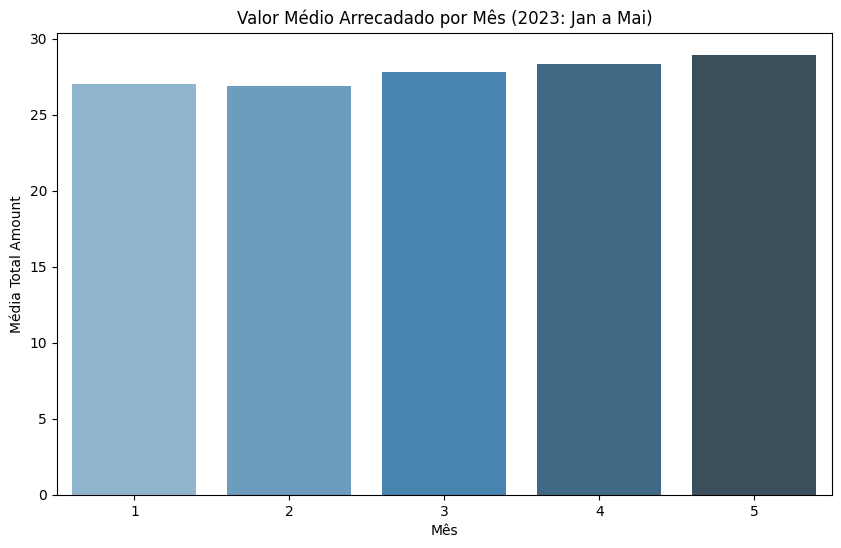

In [6]:
# Filtrando data, pois o dataset traz outros meses e anos
df_avg_total = df_processed.filter(
    (F.col("year") == 2023) & (F.col("month").between(1, 5))
).groupBy("year", "month") \
 .agg(F.avg("total_amount").alias("avg_total_amount")) \
 .orderBy("year", "month")
df_avg_total.show()

df_avg_total_pd = df_avg_total.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="month", y="avg_total_amount", data=df_avg_total_pd, palette="Blues_d")
plt.title("Valor Médio Arrecadado por Mês (2023: Jan a Mai)")
plt.xlabel("Mês")
plt.ylabel("Média Total Amount")
plt.show()

+-----------+-------------------+
|pickup_hour|avg_passenger_count|
+-----------+-------------------+
|          0| 1.4305292363293274|
|          1| 1.3852580280219302|
|          2| 1.2774563129267447|
|          3|  1.241494062156267|
|          4| 1.2609187011273182|
|          5| 1.2697023539813697|
|          6| 1.2893696222252615|
|          7| 1.3224184003150476|
|          8|  1.341381288597751|
|          9|  1.352650173417872|
|         10|  1.361454896488231|
|         11| 1.3685974933853802|
|         12|  1.379538188421399|
|         13|  1.374471104570182|
|         14|  1.364157101968565|
|         15| 1.3578495431529922|
|         16|  1.370865171652815|
|         17| 1.3829780058189471|
|         18| 1.4007293345731415|
|         19| 1.4128544083926269|
+-----------+-------------------+
only showing top 20 rows



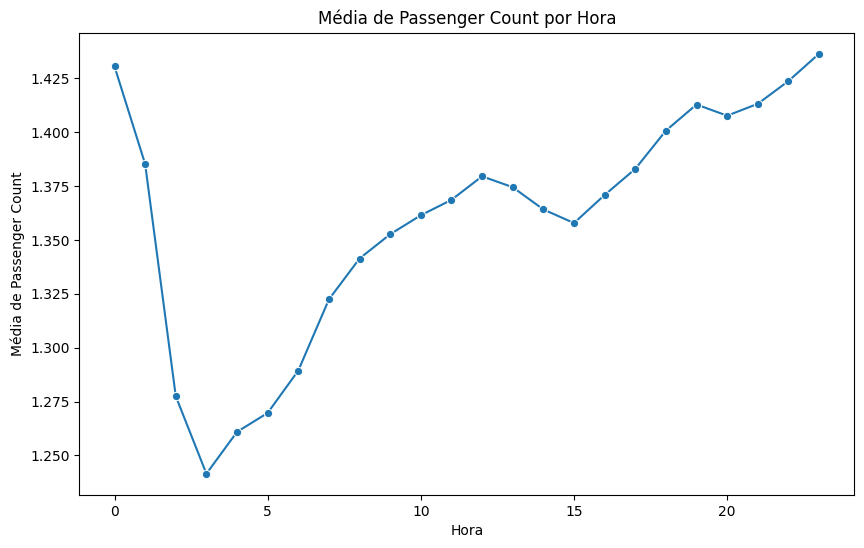

In [5]:
# Agrupa por hora de pickup
df_hourly = df_processed.groupBy(F.hour("pickup_datetime").alias("pickup_hour")) \
                        .agg(F.avg("passenger_count").alias("avg_passenger_count")) \
                        .orderBy("pickup_hour")
df_hourly.show()

df_hourly_pd = df_hourly.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="pickup_hour", y="avg_passenger_count", data=df_hourly_pd, marker="o")
plt.title("Média de Passenger Count por Hora")
plt.xlabel("Hora")
plt.ylabel("Média de Passenger Count")
plt.show()